# HW03 — Python Fundamentals
NumPy ops, dataset load/inspect, summary stats, groupby, save outputs, reusable function.

Imports & paths

In [ ]:
import os, sys, time
from pathlib import Path

# When running from project/notebooks, project_root is the parent folder
project_root = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd().resolve()
sys.path.append(str(project_root / "src"))

import numpy as np
import pandas as pd

DATA_PATH = project_root / "data"
PROCESSED_PATH = DATA_PATH / "processed"
CSV_IN = DATA_PATH / "starter_data.csv"
CSV_OUT = PROCESSED_PATH / "summary.csv"

print("Project root:", project_root)
print("Input CSV exists:", CSV_IN.exists())

Project root: C:\Users\melin\OneDrive\Desktop\nyu\python\bootcamp_panagiotis_housos\project
Input CSV exists: True


Step 1: NumPy (loop vs vectorized)

In [2]:
arr = np.arange(1_000_00, dtype=np.float64)  # 100k for quick demo

t0 = time.perf_counter()
loop_res = [x * 1.23 + 5 for x in arr]
t1 = time.perf_counter()

t2 = time.perf_counter()
vec_res = arr * 1.23 + 5
t3 = time.perf_counter()

print(f"Loop time: {(t1 - t0):.4f}s")
print(f"Vectorized time: {(t3 - t2):.4f}s")
print("First 3 (loop):", loop_res[:3])
print("First 3 (vec): ", vec_res[:3])

Loop time: 0.0283s
Vectorized time: 0.0024s
First 3 (loop): [np.float64(5.0), np.float64(6.23), np.float64(7.46)]
First 3 (vec):  [5.   6.23 7.46]


Step 2: Load & inspect CSV

In [3]:
df = pd.read_csv(CSV_IN)

print("Shape:", df.shape)
display(df.head())      # .head()
df_info = df.info()     # .info()

Shape: (10, 3)


,category,value,date
0,A,10,2025-08-01
1,B,15,2025-08-02
2,A,12,2025-08-03
3,B,18,2025-08-04
4,C,25,2025-08-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  10 non-null     object
 1   value     10 non-null     int64 
 2   date      10 non-null     object
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


Step 3: Summary statistics

In [5]:
summary = df.describe()
display(summary)


,value
count,10.000000
mean,17.600000
std,7.381659
min,10.000000
25%,12.250000
50%,14.500000
75%,23.250000
max,30.000000


In [13]:
import pandas as pd, numpy as np

print("pandas version:", pd.__version__)
print(df.dtypes)

# detect candidate categorical columns (strings/categories)
cat_cols = [c for c in df.columns if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
print("Candidate categorical columns:", cat_cols)

# strictly numeric columns only
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns used for aggregation:", num_cols)


pandas version: 2.3.1
category    object
value        int64
date        object
dtype: object
Candidate categorical columns: ['category', 'date']
Numeric columns used for aggregation: ['value']


Step 3: Groupby by category

In [14]:
import numpy as np

cat_col = "category"              # <-- pick the categorical column (not "date")
num_cols = ["value"]              # <-- the numeric column(s)

grouped = (
    df[[cat_col] + num_cols]
    .groupby(cat_col, dropna=False)[num_cols]
    .mean()
    .reset_index()
)
display(grouped)


,category,value
0,A,11.500000
1,B,15.666667
2,C,27.666667


In [15]:
summary = df.select_dtypes(include=[np.number]).describe()
display(summary)


,value
count,10.000000
mean,17.600000
std,7.381659
min,10.000000
25%,12.250000
50%,14.500000
75%,23.250000
max,30.000000


Step 4: Save outputs (+ basic plot)

Saved: C:\Users\melin\OneDrive\Desktop\nyu\python\bootcamp_panagiotis_housos\project\data\processed\summary.csv
Saved: C:\Users\melin\OneDrive\Desktop\nyu\python\bootcamp_panagiotis_housos\project\data\processed\summary.json


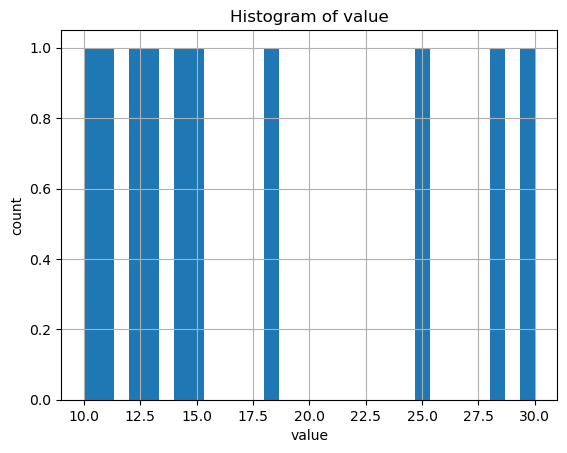

Saved: C:\Users\melin\OneDrive\Desktop\nyu\python\bootcamp_panagiotis_housos\project\data\processed\hist.png


In [16]:
from pathlib import Path
import matplotlib.pyplot as plt

PROCESSED_PATH = (project_root / "data" / "processed")
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

# Save summary
summary.to_csv(PROCESSED_PATH / "summary.csv", index=True)
summary.to_json(PROCESSED_PATH / "summary.json", orient="table")
print("Saved:", PROCESSED_PATH / "summary.csv")
print("Saved:", PROCESSED_PATH / "summary.json")

# Bonus: histogram of 'value'
ax = df["value"].hist(bins=30)
ax.set_title("Histogram of value")
ax.set_xlabel("value")
ax.set_ylabel("count")
ax.get_figure().savefig(PROCESSED_PATH / "hist.png", bbox_inches="tight")
plt.show()
print("Saved:", PROCESSED_PATH / "hist.png")

Step 5: Reusable function 

In [20]:
# project/src/utils.py
from __future__ import annotations
import numpy as np
import pandas as pd

def get_summary_stats(
    df: pd.DataFrame,
    by: str | None = None,
    agg: str | list[str] | dict[str, str] = "mean",
    keep_na_groups: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame | None]:
    
    # Select numeric columns explicitly (version-safe)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Summary over numeric columns (empty DF if no numeric cols)
    summary = df[numeric_cols].describe() if numeric_cols else pd.DataFrame()

    grouped = None
    if by is not None:
        if by not in df.columns:
            raise KeyError(f"Column '{by}' not found in DataFrame.")
        if numeric_cols:
            # Restrict to group key + numeric columns, then aggregate
            to_agg = df[[by] + numeric_cols].copy()
            grouped = (
                to_agg.groupby(by, dropna=not keep_na_groups)[numeric_cols]
                .agg(agg)
                .reset_index()
            )
        else:
            grouped = None  # nothing numeric to aggregate

    return summary, grouped



In [ ]:
from utils import get_summary_stats

summary, grouped = get_summary_stats(df, by="category")  # or by=None
display(summary)
if grouped is not None:
    display(grouped)